In [1]:
import pandas as pd
import numpy as np

In [2]:
X_train_reputable = pd.read_csv("../cnn_tnx_based/reputable_train.csv")
# X_test_reputable = pd.read_csv("reputable_test.csv")

# LSTM-Based Autoencoder

## Architecture

In [3]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
import kerastuner as kt
import numpy as np
# from tensorflow.keras.preprocessing.sequence import pad_sequences
import cudf
import cupy as cp

# Define the CAE model with extended hyperparameters
class LSTMHyperModel(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        input_seq = Input(shape=self.input_shape)

        # Encoder
        x = LSTM(units=hp.Int('lstm_units_1', min_value=16, max_value=128, step=16), 
                 activation=hp.Choice('activation', values=['relu', 'tanh']), 
                 return_sequences=True, 
                 kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_reg_1', min_value=0, max_value=0.1, step=0.01)))(input_seq)
        x = Dropout(hp.Float('dropout_1', min_value=0, max_value=0.5, step=0.1))(x)
        x = LSTM(units=hp.Int('lstm_units_2', min_value=8, max_value=64, step=8), 
                 activation=hp.Choice('activation', values=['relu', 'tanh']), 
                 return_sequences=False, 
                 kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_reg_2', min_value=0, max_value=0.1, step=0.01)))(x)

        # Decoder
        x = RepeatVector(self.input_shape[0])(x)  # Repeat the output to match the input sequence length
        x = LSTM(units=hp.Int('lstm_units_2', min_value=8, max_value=64, step=8), 
                 activation=hp.Choice('activation', values=['relu', 'tanh']), 
                 return_sequences=True)(x)
        x = Dropout(hp.Float('dropout_2', min_value=0, max_value=0.5, step=0.1))(x)
        x = LSTM(units=hp.Int('lstm_units_1', min_value=16, max_value=128, step=16), 
                 activation=hp.Choice('activation', values=['relu', 'tanh']), 
                 return_sequences=True)(x)

        decoded = TimeDistributed(Dense(self.input_shape[1], activation='sigmoid'))(x)

        model = Model(input_seq, decoded)
        model.compile(optimizer=tf.keras.optimizers.Adam(
                          hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='mse')
        return model

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))  # Ensure the output is a float

lr_scheduler = LearningRateScheduler(scheduler)

def prepare_data_gpu(df, max_timesteps):
    # Convert pandas DataFrame to cuDF DataFrame
    df_cudf = cudf.from_pandas(df)

    # Group transactions by contract address
    grouped = df_cudf.groupby('address')

    # Prepare sequences using cuDF and cuPy
    sequences = []
    addresses = []
    
    # Iterate over grouped addresses
    for address, group in grouped:
        # Drop unwanted columns and convert to cuPy array
        sequence = cp.asarray(group.drop(columns=["address", "timeStamp"]).to_pandas().values)
        
        # Handle long sequences by splitting into multiple segments
        if len(sequence) > max_timesteps:
            # Split sequence into segments of max_timesteps
            num_segments = int(cp.ceil(len(sequence) / max_timesteps))
            for i in range(num_segments):
                sub_sequence = sequence[i * max_timesteps: (i + 1) * max_timesteps]
                sequences.append(sub_sequence)
                addresses.append(address)
        else:
            sequences.append(sequence)
            addresses.append(address)

    # Pad sequences to ensure uniform length using list comprehension directly
    X_padded = cp.array([cp.pad(seq, ((0, max_timesteps - len(seq)), (0, 0)), mode='constant') if len(seq) < max_timesteps else seq for seq in sequences])

    return X_padded, addresses

# Set a reasonable max_timesteps value
max_timesteps = 24  # Adjust based on your data distribution analysis

# Prepare data without losing transactions using GPU acceleration
X_rep, addresses_rep = prepare_data_gpu(X_train_reputable, max_timesteps)

2024-10-12 12:50:26.623903: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-12 12:50:26.815572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-12 12:50:26.894290: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-12 12:50:26.913509: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-12 12:50:27.054651: I tensorflow/core/platform/cpu_feature_guar

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import matplotlib.pyplot as plt
import keras_tuner as kt
import numpy as np
import tensorflow as tf

# Function to perform K-Fold Cross-Validation and Batch size tuning for LSTM Autoencoder
def train_and_evaluate(X, max_timesteps, batch_sizes=[16, 32, 64]):
    
    histories = {}
    tuning_results = []  # Store tuning results

    for batch_size in batch_sizes:
        fold_no = 1
        
        # Reinitialize the split generator for each batch size
        tscv = TimeSeriesSplit(n_splits=5)
        split_generator = tscv.split(X)
        
        for train_index, val_index in split_generator:
            X_train, X_val = X[train_index], X[val_index]
            
            # Define the model
            hypermodel = LSTMHyperModel(input_shape=(max_timesteps, X.shape[2]))
            tuner = kt.RandomSearch(
                hypermodel,
                objective='val_loss',
                max_trials=5,
                executions_per_trial=1,
                directory='tuner_dir',
                project_name=f'lstm_tuning_tnx_{batch_size}'
            )

            # Perform hyperparameter search WITHOUT the LearningRateScheduler
            tuner.search(X_train, X_train, epochs=30, batch_size=batch_size, validation_data=(X_val, X_val))

            # Get the best hyperparameters and store them
            best_hp = tuner.oracle.get_best_trials(1)[0].hyperparameters.values
            best_trial = tuner.oracle.get_best_trials(1)[0]
            val_loss_history = best_trial.metrics.get_history('val_loss')
            best_val_loss = val_loss_history[-1]  # Get the last validation loss value (best)

            # Append the results including best validation loss
            tuning_results.append({
                'batch_size': batch_size,
                'fold': fold_no,
                'lstm_units_1': best_hp['lstm_units_1'],
                'lstm_units_2': best_hp['lstm_units_2'],
                'learning_rate': best_hp['learning_rate'],
                'activation': best_hp['activation'], 
                'l2_reg_1': best_hp['l2_reg_1'],
                'l2_reg_2': best_hp['l2_reg_2'],
                'dropout_1': best_hp['dropout_1'],
                'dropout_2': best_hp['dropout_2'],
                'val_loss': best_val_loss
            })

            # Get the best model
            best_model = tuner.get_best_models(num_models=1)[0]
            best_model.save(f"lstm_tnx_{batch_size}.keras")

            # Now fit the best model with the LearningRateScheduler
            history = best_model.fit(
                X_train, X_train,
                epochs=30,
                batch_size=batch_size,
                validation_data=(X_val, X_val),
                callbacks=[lr_scheduler]  # Add the scheduler after finding the best model
            )

            # Initialize histories for the current batch size if not done already
            if batch_size not in histories:
                histories[batch_size] = {'train_loss': [], 'val_loss': []}
                
            # Collect the loss histories for the current fold
            histories[batch_size]['train_loss'].append(history.history['loss'])
            histories[batch_size]['val_loss'].append(history.history['val_loss'])
            
            fold_no += 1
    
    # Plot training and validation loss for different batch sizes
    plt.figure(figsize=(12, 6))
    for batch_size in batch_sizes:
        # Safeguard against missing data
        if batch_size in histories:
            train_loss_avg = np.mean(histories[batch_size]['train_loss'], axis=0)
            val_loss_avg = np.mean(histories[batch_size]['val_loss'], axis=0)
            
            # Create a new figure for each batch size
            plt.figure(figsize=(8, 5))
            plt.plot(train_loss_avg, label=f'Training Loss (batch={batch_size})')
            plt.plot(val_loss_avg, '--', label=f'Validation Loss (batch={batch_size})')
            
            # Set plot title and labels
            plt.title(f'Training and Validation Loss for Batch Size {batch_size}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            
            # Show the plot
            plt.show()
    
    # Hyperparameter tuning results as a DataFrame
    tuning_df = pd.DataFrame(tuning_results)
    
    # Print the hyperparameter tuning results
    print("\nHyperparameter Tuning Results:")
    print(tuning_df)

    # Save the tuning results to a CSV for later analysis
    tuning_df.to_csv('hyperparameter_tuning_results_lstm.csv', index=False)

    return best_model, tuning_df


Trial 5 Complete [00h 01m 12s]
val_loss: 0.14033347368240356

Best val_loss So Far: 0.02169201895594597
Total elapsed time: 00h 07m 23s
Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0225 - val_loss: 0.0218 - learning_rate: 0.0069
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0223 - val_loss: 0.0219 - learning_rate: 0.0069
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0225 - val_loss: 0.0219 - learning_rate: 0.0069
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0226 - val_loss: 0.0220 - learning_rate: 0.0069
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0224 - val_loss: 0.0219 - learning_rate: 0.0069
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0227 - val_loss: 0.0217 - learning_rate: 0.0069
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0226 - val_loss: 0.0218 - learning_rate: 0.0069
Epoch 8/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0224 - val_loss: 0.0217 - learning_rate:

<Figure size 1200x600 with 0 Axes>

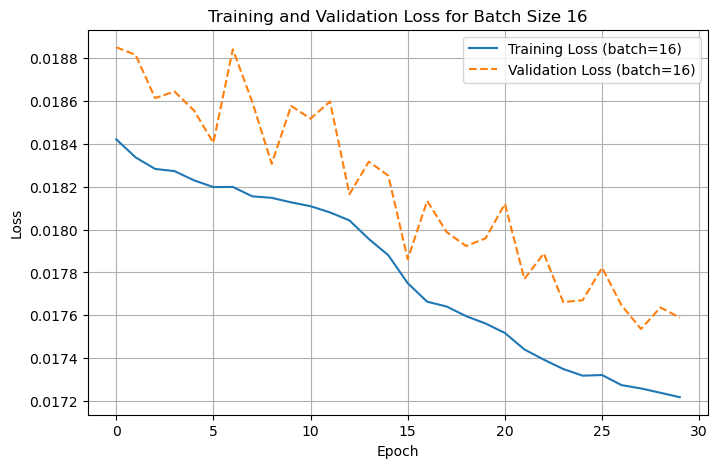

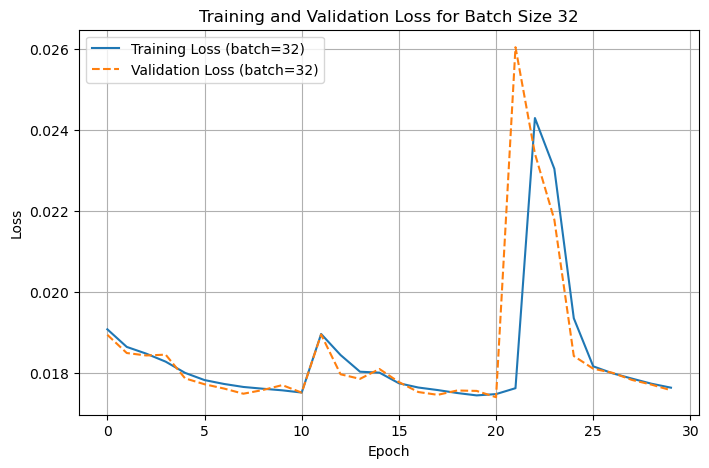

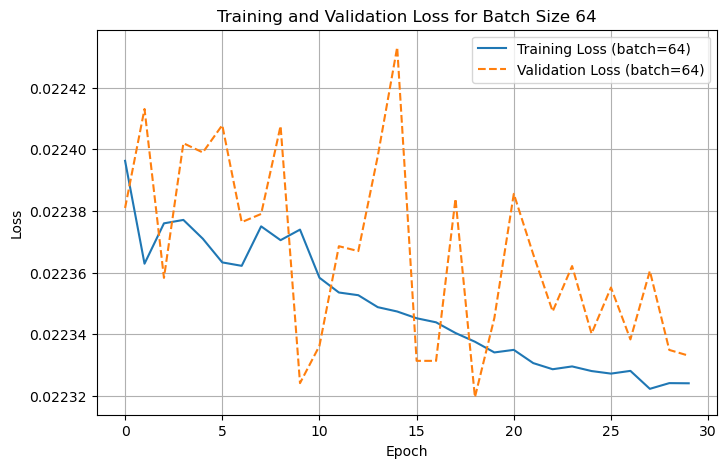


Hyperparameter Tuning Results:
    batch_size  fold  lstm_units_1  lstm_units_2  learning_rate activation  \
0           16     1            64            16       0.000310       relu   
1           16     2            64            16       0.000310       relu   
2           16     3            64            16       0.000310       relu   
3           16     4            64            16       0.000310       relu   
4           16     5            64            16       0.000310       relu   
5           32     1            32            64       0.000229       relu   
6           32     2            32            64       0.000229       relu   
7           32     3            32            64       0.000229       relu   
8           32     4            32            64       0.000229       relu   
9           32     5            32            64       0.000229       relu   
10          64     1            16             8       0.006859       tanh   
11          64     2            

In [5]:
X_rep = X_rep.get()
model, tuning_df = train_and_evaluate(X=X_rep, max_timesteps=max_timesteps)

In [23]:
model = tf.keras.models.load_model("lstm_tnx_16.keras")

/home/malikcyrus/anaconda3/envs/multimodal-env/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [24]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import cudf
import cupy as cp
from cudf.core.column import as_column
from cupy import pad

X_test_reputable = pd.read_csv("../cnn_tnx_based/reputable_test.csv")
def prepare_data_gpu(df, max_timesteps):
    # Convert pandas DataFrame to cuDF DataFrame
    df_cudf = cudf.from_pandas(df)

    # Group transactions by contract address
    grouped = df_cudf.groupby('address')

    # Prepare sequences using cuDF and cuPy
    sequences = []
    addresses = []
    
    # Iterate over grouped addresses
    for address, group in grouped:
        # Drop unwanted columns and convert to cuPy array
        sequence = cp.asarray(group.drop(columns=["address", "timeStamp"]).to_pandas().values)
        
        # Handle long sequences by splitting into multiple segments
        if len(sequence) > max_timesteps:
            # Split sequence into segments of max_timesteps
            num_segments = int(cp.ceil(len(sequence) / max_timesteps))
            for i in range(num_segments):
                sub_sequence = sequence[i * max_timesteps: (i + 1) * max_timesteps]
                sequences.append(sub_sequence)
                addresses.append(address)
        else:
            sequences.append(sequence)
            addresses.append(address)

    # Pad sequences to ensure uniform length using list comprehension directly
    X_padded = cp.array([cp.pad(seq, ((0, max_timesteps - len(seq)), (0, 0)), mode='constant') if len(seq) < max_timesteps else seq for seq in sequences])

    return X_padded, addresses

# Set a reasonable max_timesteps value
max_timesteps = 24  # Adjust based on your data distribution analysis

# Prepare data without losing transactions using GPU acceleration
X_rep, addresses_rep = prepare_data_gpu(X_test_reputable, max_timesteps)

In [25]:
import cupy as cp
# X_rep = cp.load("X_24.npy").get()
X_rep = X_rep.get()
# addresses = df['address'].unique()

# Step 1: Predict the reconstructed sequences using the trained model
reconstructed_X = model.predict(X_rep)

# Step 2: Initialize a list to store reconstruction errors per transaction
transaction_errors = []

# Step 3: Calculate reconstruction error per transaction across all contracts
for i in range(X_rep.shape[0]):  # For each contract (or address)
    address = addresses_rep[i]  # Get the corresponding address
    original_sequence = X_rep[i]
    reconstructed_sequence = reconstructed_X[i]
    
    # Calculate MSE for each transaction within the contract
    for j in range(original_sequence.shape[0]):  # For each transaction in the contract
        # Skip padded transactions (assuming they are zero-padded)
        if np.all(original_sequence[j] == 0):
            continue
        
        # Calculate reconstruction error (MSE) for the current transaction
        transaction_error = np.mean(np.square(original_sequence[j] - reconstructed_sequence[j]))
        
        # Append the error with the address and transaction index
        transaction_errors.append({
            'address': address,           # Contract address
            'transaction_index': j,       # Index of the transaction in the sequence
            'reconstruction_error': transaction_error
        })

# Convert to DataFrame for easier handling if needed
transaction_error_df_rep = pd.DataFrame(transaction_errors)
transaction_error_df_rep['contract_status'] = 1

314/314 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step


In [26]:
ill_df = pd.read_csv("../transactions/illicit_transactions_H.csv")
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ill_df[ill_df.drop(columns=["address", "timeStamp"]).columns] = scaler.fit_transform(ill_df[ill_df.drop(columns=["address", "timeStamp"]).columns])

max_timesteps = 24
def prepare_data(df, max_timesteps):
    sequences = [group[df.drop(columns=["address", "timeStamp"]).columns].values
                 for _, group in df.groupby('address')]
    X = pad_sequences(sequences, maxlen=max_timesteps, dtype='float32', padding='post', truncating='post')
    return X

X_ill = prepare_data(ill_df, max_timesteps)

addresses = ill_df['address'].unique()

# Step 1: Predict the reconstructed sequences using the trained model
reconstructed_X = model.predict(X_ill)

# Step 2: Initialize a list to store reconstruction errors per transaction
transaction_errors = []

# Step 3: Calculate reconstruction error per transaction across all contracts
for i in range(X_ill.shape[0]):  # For each contract (or address)
    address = addresses[i]  # Get the corresponding address
    original_sequence = X_ill[i]
    reconstructed_sequence = reconstructed_X[i]
    
    # Calculate MSE for each transaction within the contract
    for j in range(original_sequence.shape[0]):  # For each transaction in the contract
        # Skip padded transactions (assuming they are zero-padded)
        if np.all(original_sequence[j] == 0):
            continue
        
        # Calculate reconstruction error (MSE) for the current transaction
        transaction_error = np.mean(np.square(original_sequence[j] - reconstructed_sequence[j]))
        
        # Append the error with the address and transaction index
        transaction_errors.append({
            'address': address,           # Contract address
            'transaction_index': j,       # Index of the transaction in the sequence
            'reconstruction_error': transaction_error
        })

# Convert to DataFrame for easier handling if needed
transaction_error_df_ill = pd.DataFrame(transaction_errors)
transaction_error_df_ill['contract_status'] = 0

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step


In [27]:
reconstruction_df = pd.concat([transaction_error_df_rep, transaction_error_df_ill], ignore_index=True)

In [56]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# Define the search space for thresholds
thresholds = np.arange(75, 95, 5)  # Percentiles for reconstruction error threshold
contract_thresholds = np.arange(0.1, 0.7, 0.01)  # Contract-level anomaly thresholds

# Variables to store the best metrics
best_f1 = 0
best_params = {}

# Iterate over each combination of thresholds
for thresh in thresholds:
    for contract_thresh in contract_thresholds:
        # Calculate transaction-level anomaly threshold
        transaction_threshold = np.percentile(reconstruction_df['reconstruction_error'], thresh)
        reconstruction_df['is_anomalous'] = reconstruction_df['reconstruction_error'] > transaction_threshold

        # Calculate contract-level anomaly scores
        contract_anomaly_scores = reconstruction_df.groupby('address')['is_anomalous'].mean()
        predicted_illicit = contract_anomaly_scores > contract_thresh

        # Merge with the actual labels for evaluation
        results_df = pd.DataFrame({
            'address': contract_anomaly_scores.index,
            'anomaly_score': contract_anomaly_scores.values,
            'predicted_illicit': predicted_illicit,
            'actual_illicit': reconstruction_df.groupby('address')['contract_status'].first().apply(lambda x: 1 - x)
        })

        # Calculate evaluation metrics
        f1 = f1_score(results_df['actual_illicit'], results_df['predicted_illicit'])
        
        # Check if this combination is better
        if f1 > best_f1:
            best_f1 = f1
            best_params = {'threshold': thresh, 'contract_threshold': contract_thresh}

# Output the best parameters and F1-score
print(f"Best F1-score: {best_f1}")
print(f"Best parameters: {best_params}")


Best F1-score: 0.9090909090909091
Best parameters: {'threshold': 90, 'contract_threshold': 0.30999999999999994}


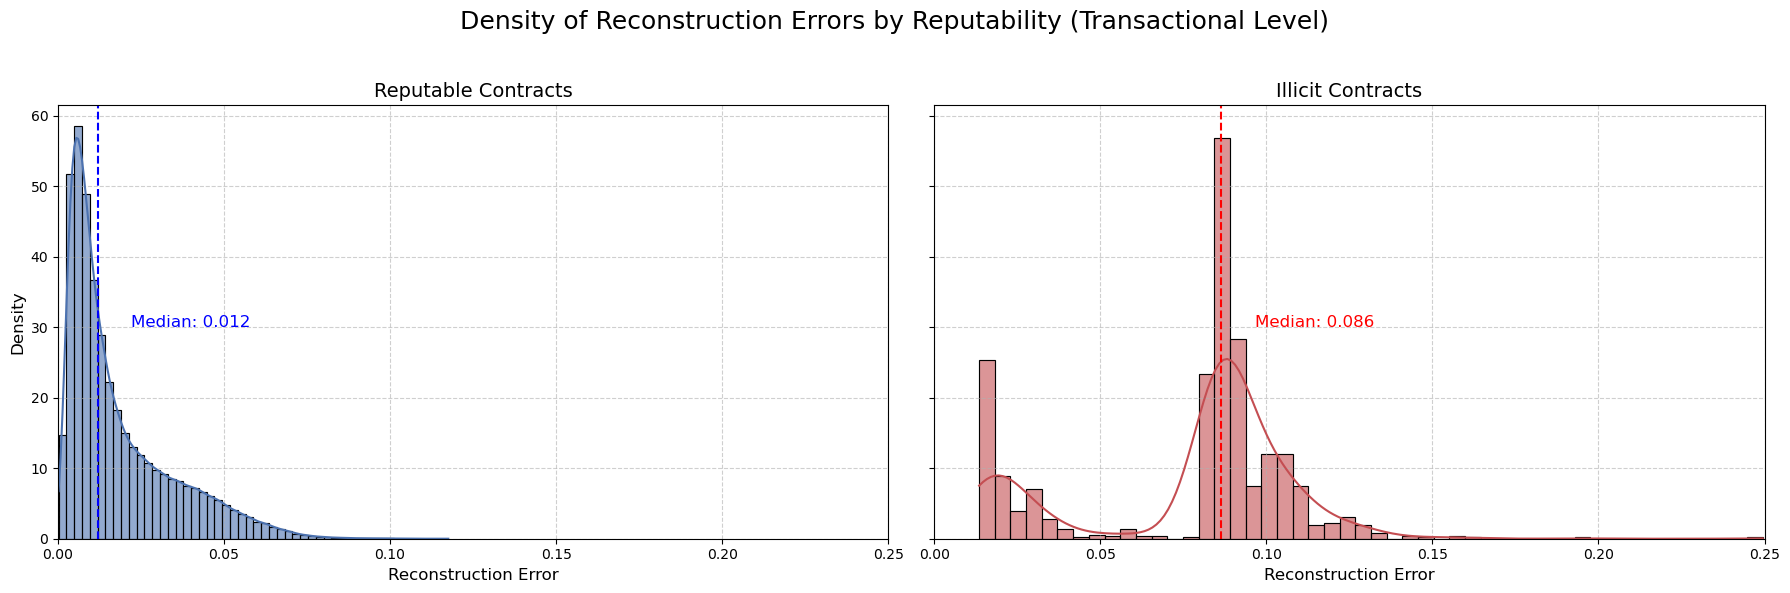

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate median values for annotations
median_reputable = reconstruction_df[reconstruction_df['contract_status'] == 1]['reconstruction_error'].median()
median_illicit = reconstruction_df[reconstruction_df['contract_status'] == 0]['reconstruction_error'].median()

# Create two subplots: one for is_reputable=1 (reputable) and one for is_reputable=0 (illicit)
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Common x-axis limit
x_limit = (0, 0.25)  # Adjust according to your data range

# Plot for is_reputable = 1 (reputable) with density
sns.histplot(reconstruction_df[reconstruction_df['contract_status'] == 1]['reconstruction_error'], 
             bins=50, kde=True, color='#4C72B0', stat='density', ax=axes[0], alpha=0.6)
axes[0].set_title('Reputable Contracts', fontsize=14)
axes[0].set_xlabel('Reconstruction Error', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_xlim(x_limit)
axes[0].grid(True, linestyle='--', alpha=0.6)

# Annotate median
axes[0].axvline(median_reputable, color='blue', linestyle='--')
axes[0].text(median_reputable + 0.01, 30, f'Median: {median_reputable:.3f}', color='blue', fontsize=12)

# Plot for is_reputable = 0 (illicit) with density
sns.histplot(reconstruction_df[reconstruction_df['contract_status'] == 0]['reconstruction_error'], 
             bins=50, kde=True, color='#C44E52', stat='density', ax=axes[1], alpha=0.6)
axes[1].set_title('Illicit Contracts', fontsize=14)
axes[1].set_xlabel('Reconstruction Error', fontsize=12)
axes[1].set_xlim(x_limit)
axes[1].grid(True, linestyle='--', alpha=0.6)

# Annotate median
axes[1].axvline(median_illicit, color='red', linestyle='--')
axes[1].text(median_illicit + 0.01, 30, f'Median: {median_illicit:.3f}', color='red', fontsize=12)

# Set a common title and adjust layout
fig.suptitle('Density of Reconstruction Errors by Reputability (Transactional Level)', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
plt.show()


In [68]:
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, classification_report, roc_auc_score

# Set the anomaly detection threshold
threshold = np.percentile(reconstruction_df['reconstruction_error'], 90)
reconstruction_df['is_anomalous'] = reconstruction_df['reconstruction_error'] > threshold

# Aggregate anomalies at the contract level
contract_anomaly_scores = reconstruction_df.groupby('address')['is_anomalous'].mean()
predicted_illicit = contract_anomaly_scores >  0.3

# Merge with the actual labels for evaluation
results_df = pd.DataFrame({
    'address': contract_anomaly_scores.index,
    'anomaly_score': contract_anomaly_scores.values,
    'predicted_illicit': predicted_illicit,
    'actual_illicit': reconstruction_df.groupby('address')['contract_status'].first().apply(lambda x: 1 - x)
})

# Evaluate the performance
print("Confusion Matrix:")
cm = confusion_matrix(results_df['actual_illicit'], results_df['predicted_illicit'])
print(cm)

print("\nClassification Report:")
print(classification_report(results_df['actual_illicit'], results_df['predicted_illicit'], digits=4))

print("\nAccuracy:")
print(accuracy_score(results_df['actual_illicit'], results_df['predicted_illicit']))

print("\nAUC:")
print(roc_auc_score(results_df['actual_illicit'], results_df['predicted_illicit']))

Confusion Matrix:
[[282   9]
 [  6  70]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9792    0.9691    0.9741       291
           1     0.8861    0.9211    0.9032        76

    accuracy                         0.9591       367
   macro avg     0.9326    0.9451    0.9387       367
weighted avg     0.9599    0.9591    0.9594       367


Accuracy:
0.9591280653950953

AUC:
0.9450623982637005
